# Gene Centric Coverage of Pathway Databases 

This notebook explores the core of genes that are part of three of the major pathway databases (KEGG, Reactome, and WikiPathways)

__Summary:__ _A core of aproximately 3800 genes (core gene set) are shared between KEGG, Reactome, and WikiPathways. In other words, most of the genes are shared between these pathway databases (see Fig. 1). The majority of pathways are covered by the genes shared between the three databases (at least by one gene) (see Fig. 2). Finally, conducting a pathway enrichment using different threshold (minimum number of genes are required to enriched the pathway) to observe how the relative coverage of pathways varies (see Fig. 3)._

Author: [Daniel Domingo-Fernández](https://github.com/ddomingof)

In [1]:
from collections import Counter
import itertools as itt
import matplotlib.pyplot as plt
import matplotlib as mpl

from bio2bel_kegg.manager import Manager as KeggManager
from bio2bel_wikipathways.manager import Manager as WikiPathwaysManager
from bio2bel_reactome.manager import Manager as ReactomeManager
from bio2bel_hgnc.manager import Manager as HGNCManager

In [2]:
%matplotlib inline

Function to render the graphics

In [18]:
def plot_enriched_pathways(title, kegg, reactome, wikipathways):
    
    # Pie chart
    labels = ['Enriched', 'Not enriched']

    #colors
    colors = ['#66b3ff','#ff9999']
    
    fig = plt.figure(figsize=(25, 6))
    
    fig.suptitle(title)

    ax1 = fig.add_subplot(1, 3, 1)
    
    mpl.rcParams['font.size'] = 16

    ax1.pie(kegg, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.set_title('KEGG', fontsize=20)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  

    ax_2 = fig.add_subplot(1, 3, 2)

    ax_2.pie(reactome, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    ax_2.set_title('Reactome', fontsize=18)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax_2.axis('equal')  

    ax_3 = fig.add_subplot(1, 3, 3)

    ax_3.pie(wikipathways, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    ax_3.set_title('WikiPathways', fontsize=18)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax_3.axis('equal')  
    
    
def apply_filter(results, threshold):
    
    filtered_results = {}

    for database_name, pathways in results.items():
    
        pathways_pass_filter = []

        for pathway_name, genes_mapped in pathways.items():

            if genes_mapped < threshold:
                continue

            pathways_pass_filter.append(pathway_name)

        filtered_results[database_name] = pathways_pass_filter
        
    return filtered_results


def calculate_relative_enrichment(results, total_keggs, total_reactomes, total_wikipathways):
    
    number_of_kegg_enriched_with_filter = len(results['kegg'])
    number_of_reactome_enriched_with_filter = len(results['reactome'])
    number_of_wikipathways_enriched_with_filter = len(results['wikipathways'])

    kegg_coverage = number_of_kegg_enriched_with_filter/total_keggs # KEGG 
    reactome_coverage = number_of_reactome_enriched_with_filter/total_reactomes #Reactome
    wikipathways_coverage = number_of_wikipathways_enriched_with_filter/total_wikipathways #WikiPathways

    return kegg_coverage, reactome_coverage, wikipathways_coverage

Instantiate all the pathway database managers

In [4]:
kegg_manager = KeggManager()
wikipathways_manager = WikiPathwaysManager()
reactome_manager = ReactomeManager()
hgnc_manager = HGNCManager()

managers = [kegg_manager, wikipathways_manager, reactome_manager]

Get gene symbols present in each database and common core present in all

In [5]:
kegg_genes = kegg_manager.get_all_hgnc_symbols()
wikipathways_genes = wikipathways_manager.get_all_hgnc_symbols()
reactome_genes = reactome_manager.get_all_hgnc_symbols()

gene_universe = hgnc_manager.get_all_hgnc_symbols()

print('{} contains {} genes'.format('HGNC', len(gene_universe)))
print('{} contains {} genes'.format('KEGG', len(kegg_genes)))
print('{} contains {} genes'.format('WikiPathways', len(wikipathways_genes)))
print('{} contains {} genes\n'.format('Reactome', len(reactome_genes)))

common_genes = kegg_genes.intersection(wikipathways_genes).intersection(reactome_genes)
print('{} genes between KEGG, Reactome, and WikiPathways'.format(len(common_genes)))

HGNC contains 42465 genes
KEGG contains 7353 genes
WikiPathways contains 6064 genes
Reactome contains 10595 genes

3851 genes between KEGG, Reactome, and WikiPathways


### Gene-centric coverage of KEGG, Reactome, and WikiPathways compared to the HGNC gene symbol catalog (Gene Universe)

<img src="img/genetic_coverage.png" alt="Coverage Databases of the genetic knowledge" style="width: 400px;">

__Figure 1. Venn diagram of the gene-centric coverage of the three pathway databases studied compared to the HGNC symbol catalog.__ A core set of aproximately 3800 genes is part of all databases. Next, we proceed to study which pathways contain these common gene set.

### Explore which pathways are enriched with the core of genes present in all databases

Next, we explore the coverage of pathways using this core gene set as a probe.

In [6]:
enriched_pathways = {}

for manager in managers:
    
    proteins = [
        protein
        for gene in common_genes
        for protein in manager.query_protein_by_hgnc(gene) #Might be multiple hgnc symbols associated to uniprot (Reactome)
    ]
    
    pathways_lists = [
        protein.get_pathways_ids()
        for protein in proteins
    ]
    
    pathway_counter = Counter(itt.chain(*pathways_lists))

    enriched_pathways[manager.module_name] = pathway_counter

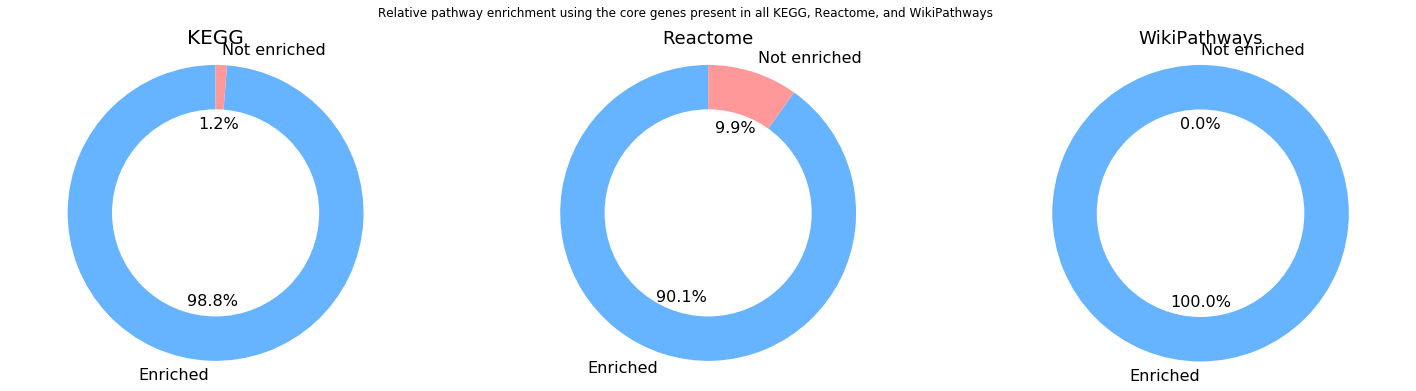

In [17]:
total_keggs = len(kegg_manager.get_all_pathway_names())
total_reactomes = len(reactome_manager.get_all_pathway_names())
total_wikipathways = len(wikipathways_manager.get_all_pathway_names())

number_of_kegg_enriched = len(enriched_pathways['kegg'])
number_of_reactome_enriched = len(enriched_pathways['reactome'])
number_of_wikipathways_enriched = len(enriched_pathways['wikipathways'])
 
kegg = [number_of_kegg_enriched, total_keggs-number_of_kegg_enriched] # KEGG 
reactome = [number_of_reactome_enriched, total_reactomes-number_of_reactome_enriched] #Reactome
wikipathways = [number_of_wikipathways_enriched, total_wikipathways-number_of_wikipathways_enriched] #WikiPathways

plot_enriched_pathways(
    'Relative pathway enrichment using the core genes present in all KEGG, Reactome, and WikiPathways',
    kegg, reactome, wikipathways
)
plt.show()

__Figure 2. The majority of pathways are covered by the genes shared between the three databases.__ The figure shows almost the totality of pathways contained at least one gene part of the common nucleus. As expected, Reactome contained a subset of pathways (~10%) which was not enriched since it is the biggest database with respect to pathway and gene size. However, the results presented show that with these core of ~3800 genes compose the core of the pathway knowledge. Future work could be conducted to find contradictions in this common knowledge, or complement the knowledge between databases.

### Zooming into the KEGG and Reactome pathways that were not enriched

In [ ]:
kegg_enriched_names = [
    kegg_manager.get_pathway_by_id(kegg_id).name
    for kegg_id in enriched_pathways['kegg']
]

kegg_not_enriched = set(kegg_manager.get_all_pathway_names()).difference(kegg_enriched_names)

print('KEGG pathways not enriched by the core gene set ({}): {}\n'.format(len(kegg_not_enriched) ,kegg_not_enriched))

reactome_enriched_names = [
    reactome_manager.get_pathway_by_id(reactome_id).name
    for reactome_id in enriched_pathways['reactome']
]

reactome_not_enriched = set(reactome_manager.get_all_pathway_names()).difference(reactome_enriched_names)

print('Reactome pathways not enriched by the core gene set: {}'.format(len(reactome_not_enriched)))

# print(reactome_not_enriched)

__Not enriched pathways:__ Specific pathways containing only a few genes.

### Repeat the exercise applying a filter (pathways must contain at least X genes from the common core)

In [53]:
kegg_lines = []
reactome_lines = []
wikipathways_lines = []

for i in range(1,200):

    filtered_results = apply_filter(enriched_pathways, i)

    kegg_coverage, reactome_coverage, wikipathways_coverage = calculate_relative_enrichment(
        filtered_results, 
        total_keggs,
        total_reactomes,
        total_wikipathways
    )
    
    kegg_lines.append((i,kegg_coverage))
    reactome_lines.append((i,reactome_coverage))
    wikipathways_lines.append((i,wikipathways_coverage))

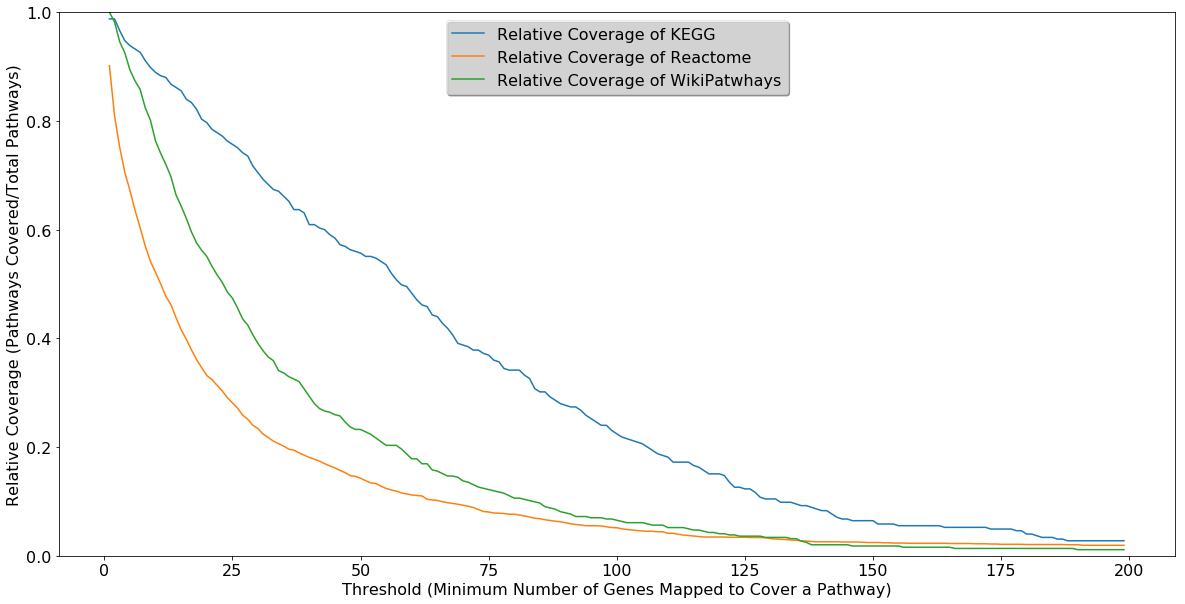

In [57]:
# Line chart
fig = plt.figure(figsize=(20, 10))


plt.plot([x for x,y in kegg_lines],[y for x,y in kegg_lines], label="Relative Coverage of KEGG")
plt.plot([x for x,y in reactome_lines],[y for x,y in reactome_lines], label="Relative Coverage of Reactome")
plt.plot([x for x,y in wikipathways_lines],[y for x,y in wikipathways_lines], label="Relative Coverage of WikiPatwhays")

axes = plt.gca()
axes.set_ylim([0,1])

axes.set_ylabel('Relative Coverage (Pathways Covered/Total Pathways)')
axes.set_xlabel('Threshold (Minimum Number of Genes Mapped to Cover a Pathway)')

leg = plt.legend(loc=9, ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()

__Figure 3. Relative coverage of pathways by using pathway enrichment applying thresholds (a minimum of genes is required to enriched the pathway).__ It is interesting to see that while Reactome and WikiPathways coverage decreases quickly, KEGG pathway coverage remains quite high. We have to keep in mind that WikiPathways contains the smallest amoung of genes (~6000) when compared to Reactome (~10000) and KEGG (~7000). This might indicate that a signficant amount of KEGG pathways comprise big amount of the genes that are part of the core gene set shared between the three databases.